In [38]:
# CITATION for dataset
# Wah, C., Branson, S., Welinder, P., Perona, P., & Belongie, S. (2022).
# CUB-200-2011 (1.0) [Data set]. CaltechDATA.
# https://doi.org/10.22002/D1.20098
# https://data.caltech.edu/records/65de6-vp158
# CITATION for labels
# Farrell, R. (2022). CUB-200-2011 Segmentations (1.0) [Data set].
# CaltechDATA. https://doi.org/10.22002/D1.20097

Browser version on google colab can be accessed through https://colab.research.google.com/drive/19SW7UNknUlt_Mw1SbkDtm771XvkBrDaN?usp=sharing

In [39]:
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
# import tarfile

In [40]:
# Unzip dataset

# with tarfile.open('/content/drive/MyDrive/datasets/cub_birds_dataset/CUB_200_2011.tgz', 'r:gz') as tar:
#     tar.extractall(path='/content/drive/MyDrive/datasets/cub_birds_dataset')
# with tarfile.open('/content/drive/MyDrive/datasets/cub_birds_dataset/segmentations.tgz', 'r:gz') as tar:
#     tar.extractall(path='/content/drive/MyDrive/datasets/cub_birds_dataset')

In [41]:
# Directories and Constants
# Please change these parameters to reach the dataset from within the code
PREFIX = "../datasets/cub_birds_dataset/"
SELECTED_DATASET_NAME = "CUB_200_2011"
DATASET_DIR = PREFIX+SELECTED_DATASET_NAME+'/'
DATASET_IMAGES_DIR = DATASET_DIR+"images/"
LABELS_IMAGES_DIR = PREFIX+"segmentations/"
FEATURE_SPACE_OUTPUT_DIR = '../datasets/cub_birds_dataset/'

# Parameters
DESIRED_IMG_HEIGHT = 256
DESIRED_BLOCK_SIZE = 16
DESIRED_CLASSES = [1, 2, 3]  # [12,13,46]
DESIRED_NUM_OF_SAMPLES = 1

RANDOM_STATE = 31

BALANACING_ELIMINATION = True
DROP_BACKGROUND = True
EXPORT_CSV = True


VERBOSE_DEBUG_MSGS = 1
VERBOSE_DEBUG_MSGS_AND_PLOTS = 2
VERBOSE = VERBOSE_DEBUG_MSGS


TEST_PORTION = 0.2

FEATURE_VECTOR_LENGTH = DESIRED_BLOCK_SIZE**2

In [42]:
# Read images names
with open(DATASET_DIR+"images.txt", 'r') as file:
    lines = file.readlines()
images = [line.rstrip('\n')[line.find(' ')+1:] for line in lines]
ids = [int(line.rstrip('\n')[:line.find(' ')]) for line in lines]
paths = [img[:-4] for img in images]
labels = [img + '.png' for img in paths]
with open(DATASET_DIR+"classes.txt", 'r') as file:
    lines = file.readlines()
classes = [line.rstrip('\n')[line.find(' ')+1:] for line in lines]
print(images)
print(paths)
print(labels)
print(ids)
print(classes)

['001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0074_59.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0014_89.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0085_92.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0031_100.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0051_796103.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0025_796057.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0023_796059.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0086_796062.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0049_796063.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0006_796065.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0040_7960

In [43]:
selected_classes=[classes[i-1] for i in DESIRED_CLASSES]
print(selected_classes)

['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross']


In [44]:
def resize(img, height, divisibility=1, interpolation=cv2.INTER_CUBIC):
  h, w = img.shape
  aspect= round(h/w,2)
  new_h = (height // divisibility) * divisibility
  new_w = int(((new_h/aspect) // divisibility) * divisibility)
  print(f'Resizing image from {h},{w} aspect: {aspect} to {new_h},{new_w} aspect:{round(new_h/new_w,2)}')
  return cv2.resize(img, dsize=(new_w,new_h), interpolation=interpolation)

In [45]:
def generate_feature_vectors(seg_card, label, block_size=DESIRED_BLOCK_SIZE):
  seg_card_h, seg_card_w = seg_card.shape
  num_v_blocks = seg_card_h-block_size+1
  num_h_blocks = seg_card_w-block_size+1
  cc = round(((num_v_blocks)*(num_h_blocks)))
  f_vec_size = block_size**2
  flatcc = np.zeros((cc, f_vec_size+1), np.uint8)
  k = 0
  for i in range(num_v_blocks):
    for j in range(num_h_blocks):
      crop_tmp = seg_card[i:i+block_size, j:j+block_size]
      flatcc[k,0:f_vec_size] = crop_tmp.flatten()
      flatcc[k,-1] = int(flatcc[k,0:f_vec_size].any())*label                      # Label assignment
      k = k + 1
  return flatcc

In [46]:
def plot_color_channels(img, seg):
  f, axes=plt.subplots(2,4)
  axes[0][0].imshow(img[...,::-1])
  axes[0][0].axis('off')
  axes[0][0].set_title('Image')
  axes[0][1].imshow(img[:,:,0])
  axes[0][1].axis('off')
  axes[0][1].set_title('Red')
  axes[0][2].imshow(img[:,:,1])
  axes[0][2].axis('off')
  axes[0][2].set_title('Green')
  axes[0][3].imshow(img[:,:,2])
  axes[0][3].axis('off')
  axes[0][3].set_title('Blue')
  axes[1][0].imshow(seg[...,::-1])
  axes[1][0].set_title('Segmented')
  axes[1][0].axis('off')
  axes[1][1].imshow(seg[:,:,0])
  axes[1][1].axis('off')
  axes[1][1].set_title('Red')
  axes[1][2].imshow(seg[:,:,1])
  axes[1][2].axis('off')
  axes[1][2].set_title('Green')
  axes[1][3].imshow(seg[:,:,2])
  axes[1][3].axis('off')
  axes[1][3].set_title('Blue')

In [47]:
def plot_grayscale(img, seg):
  f, axes=plt.subplots(1,2)
  axes[0].imshow(img, cmap=plt.get_cmap('gray'))
  axes[0].axis('off')
  axes[0].set_title('Grayscale')
  axes[1].imshow(seg, cmap=plt.get_cmap('gray'))
  axes[1].axis('off')

In [48]:
def plot_resized(img, seg):
  f, axes=plt.subplots(1,2)
  axes[0].imshow(img, cmap=plt.get_cmap('gray'))
  axes[0].axis('off')
  axes[0].set_title('Image Resized')
  axes[1].imshow(seg, cmap=plt.get_cmap('gray'))
  axes[1].axis('off')
  axes[1].set_title('Segmented Resized');

In [49]:
def plot_background_removal(seg_card):
  f, axes=plt.subplots()
  axes.imshow(seg_card, cmap=plt.get_cmap('gray'))
  axes.axis('off');

In [50]:
def pipeline(img, seg, label, show_procedures=False):
  # Main pipeline per input
  if show_procedures:
    plot_color_channels(img, seg)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)                                     # RGB 2 Gray
  seg = cv2.cvtColor(seg, cv2.COLOR_BGR2GRAY)                                     # RGB 2 Gray
  if show_procedures:
    plot_grayscale(img,seg)
  img = resize(img, DESIRED_IMG_HEIGHT, divisibility=DESIRED_BLOCK_SIZE)          # Resizing
  seg = resize(seg, DESIRED_IMG_HEIGHT, divisibility=DESIRED_BLOCK_SIZE)          # Resizing
  if show_procedures:
    plot_resized(img, seg)
  img = cv2.normalize(img.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)*255   # Normalizing
  seg = cv2.normalize(seg.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)*255   # Normalizing
  if show_procedures:
    print(f'NORMALIZED: Image(min,max): ({img.min()},{img.max()})\tSegmented(min,max): ({seg.min()},{seg.max()})')
  seg_card = seg*(img/255)                                                        # Separating Background
  if show_procedures:
    plot_background_removal(seg_card)
  fvectors = generate_feature_vectors(seg_card, label)                            # Generating features vectors list
  return pd.DataFrame(fvectors)

Showing sample image: ../datasets/cub_birds_dataset/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg
(335, 500, 3)


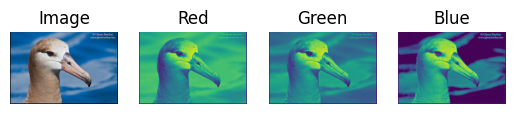

In [51]:
# Input Sample image
img=cv2.imread(DATASET_IMAGES_DIR+images[0])
print(f'Showing sample image: {DATASET_IMAGES_DIR+images[0]}')
# Input & channels plotting
f, axes=plt.subplots(1,4)
axes[0].imshow(img[...,::-1])
axes[0].axis('off')
axes[0].set_title('Image')
axes[1].imshow(img[:,:,0])
axes[1].axis('off')
axes[1].set_title('Red')
axes[2].imshow(img[:,:,1])
axes[2].axis('off')
axes[2].set_title('Green')
axes[3].imshow(img[:,:,2])
axes[3].axis('off')
axes[3].set_title('Blue')
print(img.shape)

Showing sample image: ../datasets/cub_birds_dataset/segmentations/001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.png
(335, 500, 3)


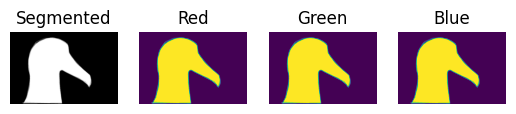

In [52]:
# Segmentation Sample image
seg=cv2.imread(LABELS_IMAGES_DIR+labels[0])
print(f'Showing sample image: {LABELS_IMAGES_DIR+labels[0]}')
f, axes=plt.subplots(1,4)
axes[0].imshow(seg[...,::-1])
axes[0].axis('off')
axes[0].set_title('Segmented')
axes[1].imshow(seg[:,:,0])
axes[1].axis('off')
axes[1].set_title('Red')
axes[2].imshow(seg[:,:,1])
axes[2].axis('off')
axes[2].set_title('Green')
axes[3].imshow(seg[:,:,2])
axes[3].axis('off')
axes[3].set_title('Blue')
print(seg.shape)

Observation Shape: 335,500
Label Shape: 335,500


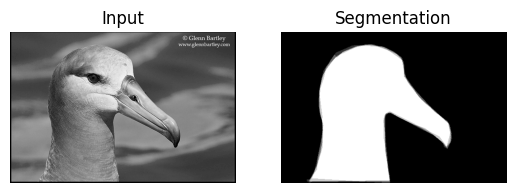

In [53]:
# RGB To Grayscale
img_gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
seg_gr = cv2.cvtColor(seg, cv2.COLOR_BGR2GRAY)
img_height, img_width = img_gr.shape
seg_height, seg_width = seg_gr.shape
print(f'Observation Shape: {img_height},{img_width}\nLabel Shape: {seg_height},{seg_width}')
f, axes=plt.subplots(1,2)
axes[0].imshow(img_gr, cmap=plt.get_cmap('gray'))
axes[0].axis('off')
axes[0].set_title('Input')
axes[1].imshow(seg_gr, cmap=plt.get_cmap('gray'))
axes[1].axis('off')
axes[1].set_title('Segmentation');

Resizing image from 335,500 aspect: 0.67 to 256,368 aspect:0.7
Resizing image from 335,500 aspect: 0.67 to 256,368 aspect:0.7


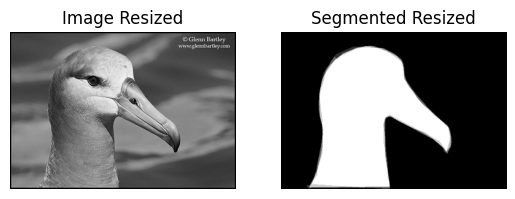

In [54]:
# Resizing
img_card = resize(img_gr, DESIRED_IMG_HEIGHT, divisibility=16)
seg_card = resize(seg_gr, DESIRED_IMG_HEIGHT, divisibility=16)
img_card_h, img_card_w = img_card.shape
seg_card_h, seg_card_w = seg_card.shape
f, axes=plt.subplots(1,2)
axes[0].imshow(img_card, cmap=plt.get_cmap('gray'))
axes[0].axis('off')
axes[0].set_title('Image Resized')
axes[1].imshow(seg_card, cmap=plt.get_cmap('gray'))
axes[1].axis('off')
axes[1].set_title('Segmented Resized');

In [55]:
# Normalizing
img_card = cv2.normalize(img_card.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)*255
seg_card = cv2.normalize(seg_card.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)*255
print(f'Image(min,max): ({img_card.min()},{img_card.max()})\Segmented(min,max): ({seg_card.min()},{seg_card.max()})')

Image(min,max): (0.0,255.0)\Segmented(min,max): (0.0,255.0)


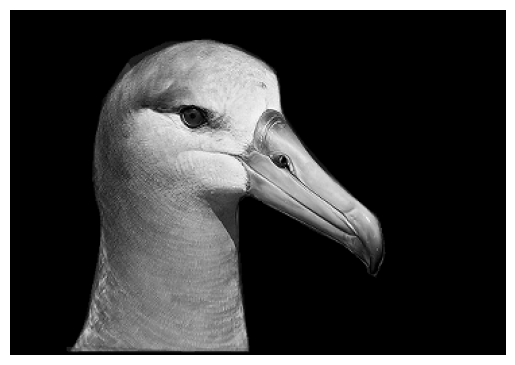

In [56]:
# Segmentation
seg_card = seg_card*(img_card/255)
plt.imshow(seg_card, cmap=plt.get_cmap('gray'))
plt.axis('off');

In [57]:
# Overlapping Block Generation
seg_card_h, seg_card_w = seg_card.shape
num_v_blocks=seg_card_h-DESIRED_BLOCK_SIZE+1
num_h_blocks=seg_card_w-DESIRED_BLOCK_SIZE+1
cc = round(((num_v_blocks)*(num_h_blocks)))
f_vec_size=DESIRED_BLOCK_SIZE**2
print(f'{cc}, {num_v_blocks}, {num_h_blocks}, {f_vec_size}')
flatcc = np.zeros((cc, f_vec_size+1), np.uint8)
k = 0
for i in range(num_v_blocks):
  for j in range(num_h_blocks):
    crop_tmp = seg_card[i:i+DESIRED_BLOCK_SIZE,j:j+DESIRED_BLOCK_SIZE]
    flatcc[k,0:f_vec_size] = crop_tmp.flatten()
    flatcc[k,-1] = int(flatcc[k,0:f_vec_size].any())*ids[0] # Label assignment
    k = k + 1

85073, 241, 353, 256


In [58]:
# Convert to Dataframe
fspace = pd.DataFrame(flatcc)

In [59]:
fspace.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85073 entries, 0 to 85072
Columns: 257 entries, 0 to 256
dtypes: uint8(257)
memory usage: 20.9 MB


In [60]:
fspace.columns

RangeIndex(start=0, stop=257, step=1)

In [61]:
def fspace_stat_descriptors(fspace):
  fvs = fspace.iloc[:,:-1]
  print(f'Number of Observations: {fvs.shape[0]}\nDimension of the data: {fvs.shape[1]}')
  means=fvs.mean(axis=0)
  print(f'Means:\n{means}')

  ax_1=means.plot.density()
  ax_1.set_title("Features Means Density Function")

  f, ax=plt.subplots(nrows=2,ncols=2, figsize=(14,7))
  ax[0][0].scatter(means.index, means.values, s=0.5)
  ax[0][0].set_title('Features Means')

  std=fvs.std(axis=0)
  ax[0][1].scatter(std.index, std.values, s=0.5)
  ax[0][1].set_title('Features Standard Deviation')

  obs_means = fvs.mean(axis=1)
  ax[1][0].scatter(obs_means.index, obs_means.values, s=0.05)
  ax[1][0].set_title('FV Means')


  count=fvs.astype(bool).sum(axis=0)
  ax[1][1].plot(count.index,count.values)
  ax[1][1].set_title('Non Background Features Count')


Number of Observations: 85073
Dimension of the data: 256
Means:
0      46.506483
1      46.506483
2      46.506483
3      46.506483
4      46.506483
         ...    
251    48.992407
252    48.992407
253    48.992407
254    48.992407
255    48.992407
Length: 256, dtype: float64


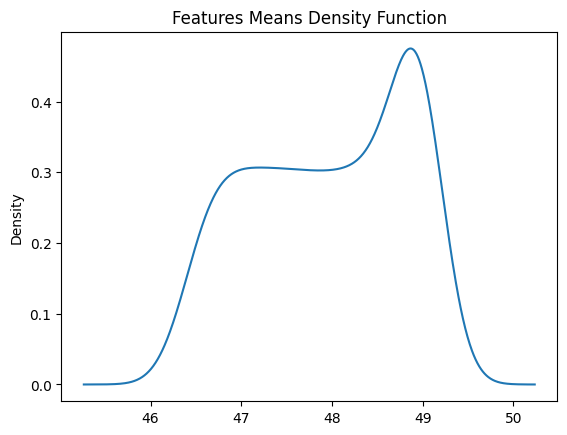

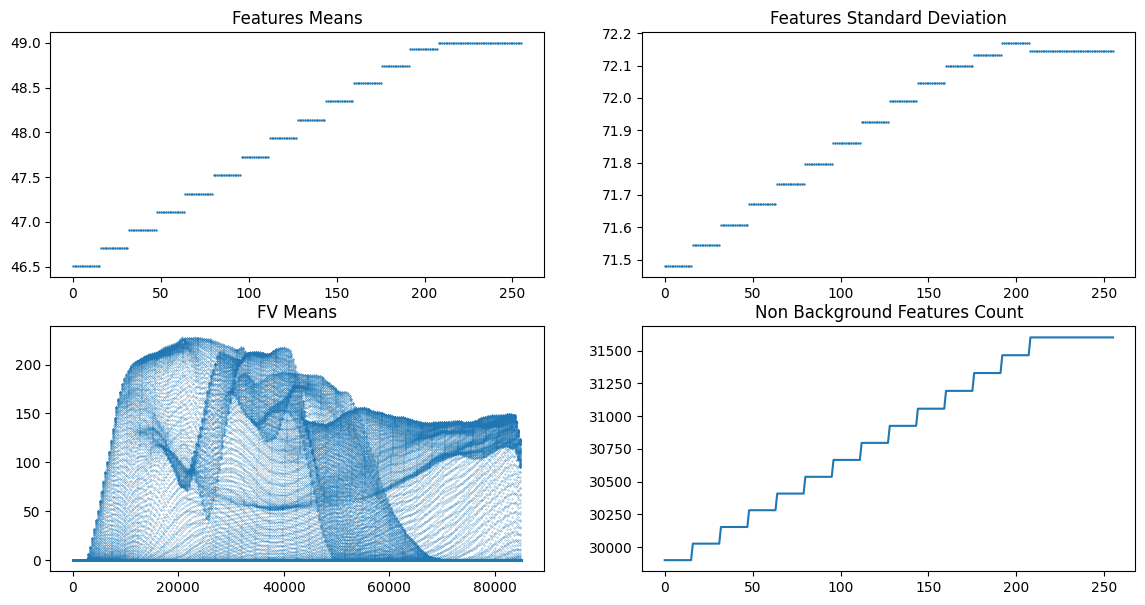

In [62]:
fspace_stat_descriptors(fspace)

In [63]:
# Save to csv
fspace.to_csv(LABELS_IMAGES_DIR+paths[0]+'.csv', index=False, header=False)

Resizing image from 335,500 aspect: 0.67 to 256,368 aspect:0.7
Resizing image from 335,500 aspect: 0.67 to 256,368 aspect:0.7
NORMALIZED: Image(min,max): (0.0,255.0)	Segmented(min,max): (0.0,255.0)
Saved dataframe to: ../datasets/cub_birds_dataset/segmentations/001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.csv
Resizing image from 375,500 aspect: 0.75 to 256,336 aspect:0.76
Resizing image from 375,500 aspect: 0.75 to 256,336 aspect:0.76
NORMALIZED: Image(min,max): (0.0,255.0)	Segmented(min,max): (0.0,255.0)
Saved dataframe to: ../datasets/cub_birds_dataset/segmentations/002.Laysan_Albatross/Laysan_Albatross_0002_1027.csv
Resizing image from 320,500 aspect: 0.64 to 256,400 aspect:0.64
Resizing image from 320,500 aspect: 0.64 to 256,400 aspect:0.64
NORMALIZED: Image(min,max): (0.0,254.99999999999997)	Segmented(min,max): (0.0,255.0)
Saved dataframe to: ../datasets/cub_birds_dataset/segmentations/003.Sooty_Albatross/Sooty_Albatross_0038_1065.csv


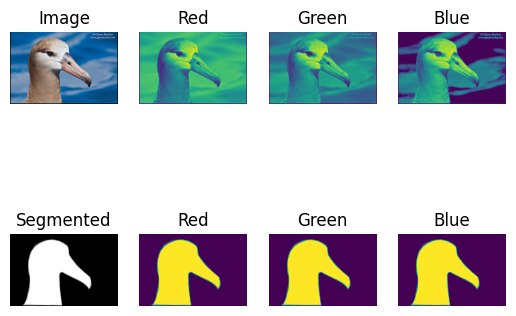

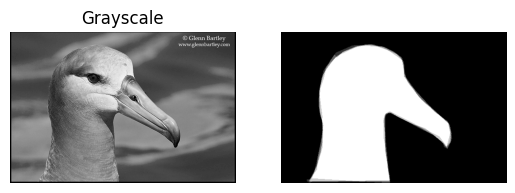

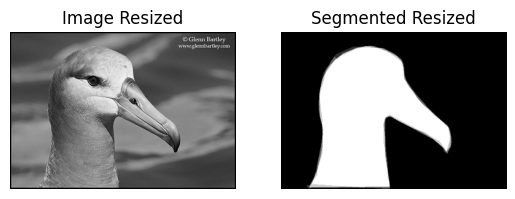

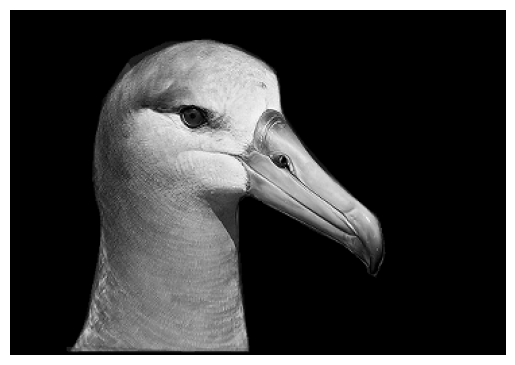

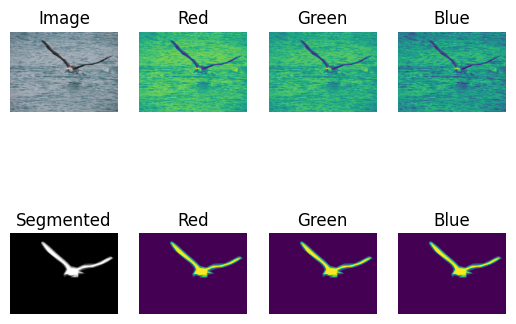

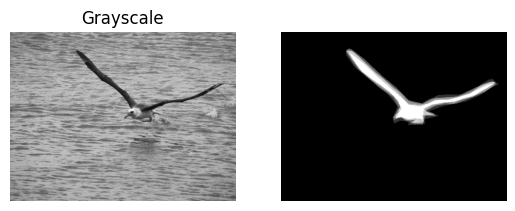

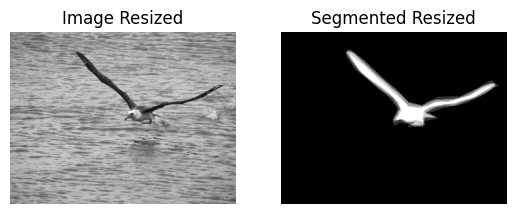

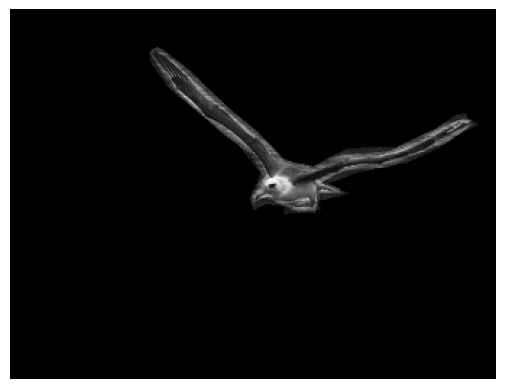

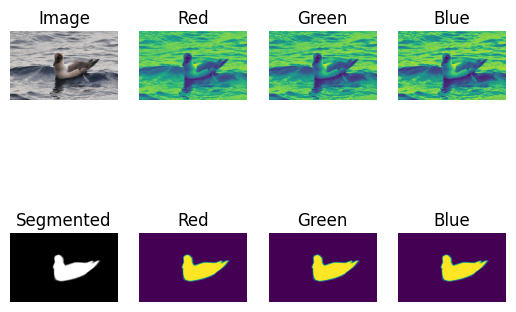

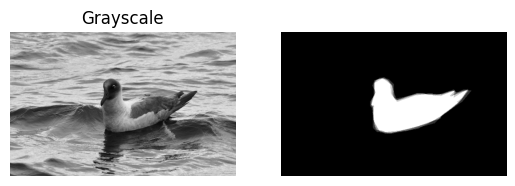

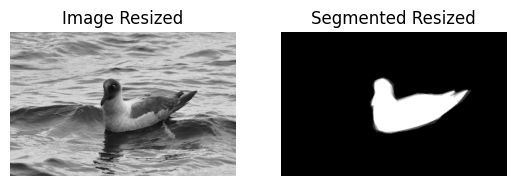

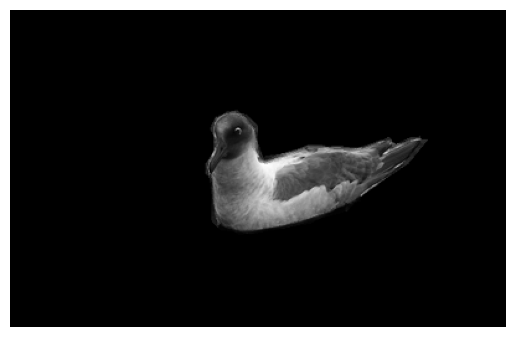

In [64]:
# Entry Point
fspace = pd.DataFrame()
for selected_class in selected_classes:
  selected_class_images=[]
  selected_class_segs=[]
  label=classes.index(selected_class)+1
  for i in range(len(images)):
    if images[i].startswith(selected_class):
      selected_class_images.append(images[i])
      selected_class_segs.append(labels[i])
    if len(selected_class_images) >= DESIRED_NUM_OF_SAMPLES:
      break
  for i in range(len(selected_class_images)):
    img=cv2.imread(DATASET_IMAGES_DIR+selected_class_images[i])
    seg=cv2.imread(LABELS_IMAGES_DIR+selected_class_segs[i])
    frame=pipeline(img, seg, label, show_procedures=True)
    frame.to_csv(LABELS_IMAGES_DIR+selected_class_images[i][:-3]+"csv",mode='w+')           # Create separate csv for each image
    print(f'Saved dataframe to: {LABELS_IMAGES_DIR+selected_class_images[i][:-3]+"csv"}')
    fspace=pd.concat([fspace, frame], axis=0)
fspace = fspace.sample(frac=1, axis=0).reset_index(drop=True)

In [65]:
fspace.to_csv(FEATURE_SPACE_OUTPUT_DIR+'_'.join([str(i) for i in DESIRED_CLASSES])+"_fs.csv",index=False,header=False,mode='w+')

In [90]:
# PARAMETERS

FEATURE_1=9 # < 255
FEATURE_2=10 # < 255
FEATURE_3=11 # < 255

In [91]:
def plot_2d_fspace(fspace, subset=10000):
  if fspace.shape[0] > subset:
    fspace = fspace.iloc[:subset,:]
  plt.scatter(x=fspace.iloc[:,FEATURE_1],y=fspace.iloc[:,FEATURE_2],c=fspace.iloc[:,-1], s=2)
  cbar = plt.colorbar(ticks=fspace.iloc[:,-1].unique())
  cbar.set_label('Classes',rotation=270)
  plt.xlabel(f'Feature {FEATURE_1}')
  plt.ylabel(f'Feature {FEATURE_2}')
  plt.title('Two Dimensional Feature Space');

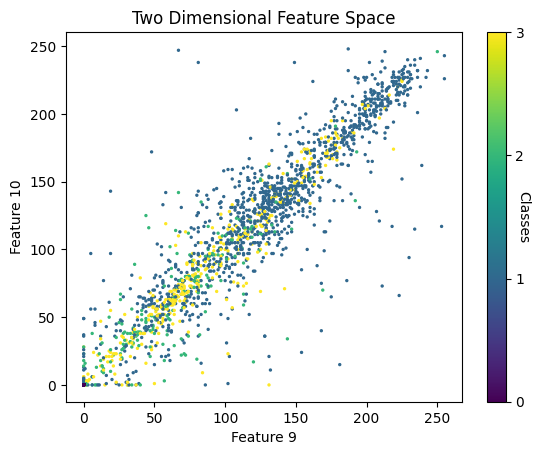

In [92]:
plot_2d_fspace(fspace)

In [93]:
def plot_3d_fspace(fspace, subset=10000):
  if fspace.shape[0] > subset:
    fspace = fspace.iloc[:subset, :]
  fig = plt.figure(figsize=(12, 12))
  ax = fig.add_subplot(projection='3d')
  ax.scatter(fspace.iloc[:,FEATURE_1], fspace.iloc[:,FEATURE_2], fspace.iloc[:,FEATURE_3], c=fspace.iloc[:,-1])
  ax.set_xlabel(f'Feature {FEATURE_1}')
  ax.set_ylabel(f'Feature {FEATURE_2}')
  ax.set_zlabel(f'Feature {FEATURE_3}')
  ax.set_title('Three Dimensional Feature Space');

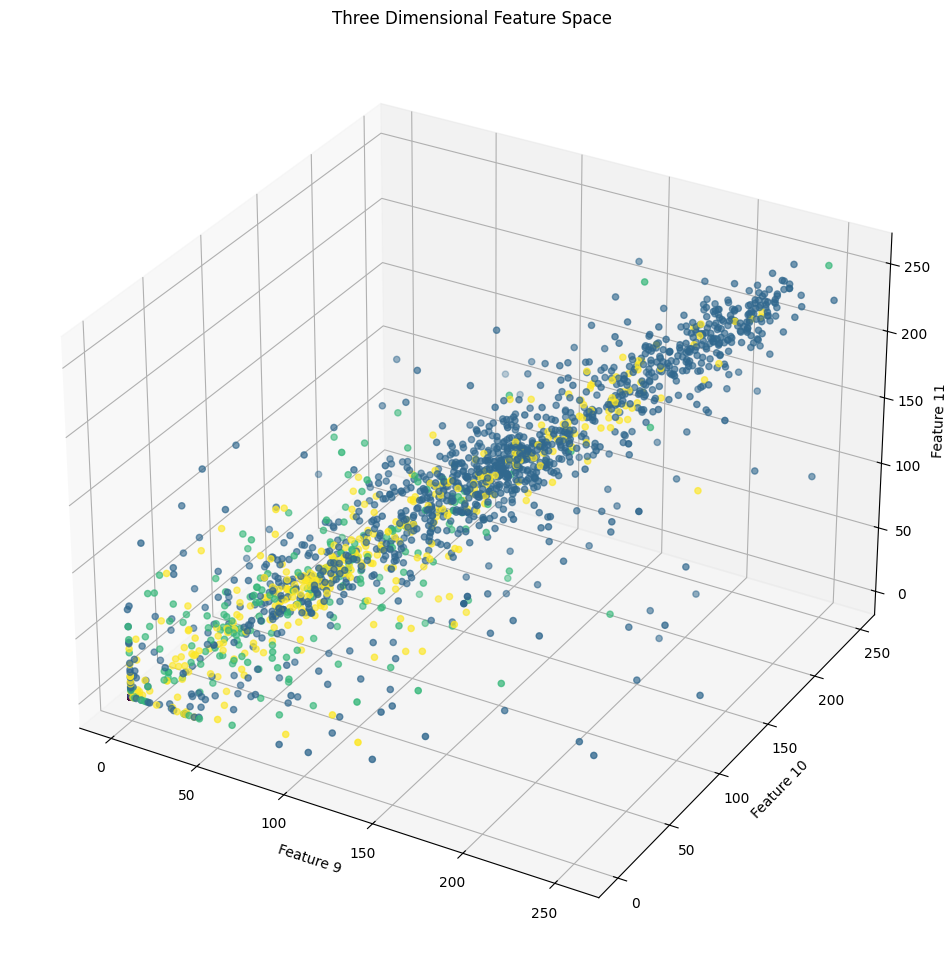

In [94]:
plot_3d_fspace(fspace)

In [95]:
fspace_2classes = fspace[fspace.iloc[:,-1].isin(fspace.iloc[:,-1].unique()[:3])]
fspace_2classes.iloc[:,-1].unique()

array([1, 3, 0], dtype=uint8)

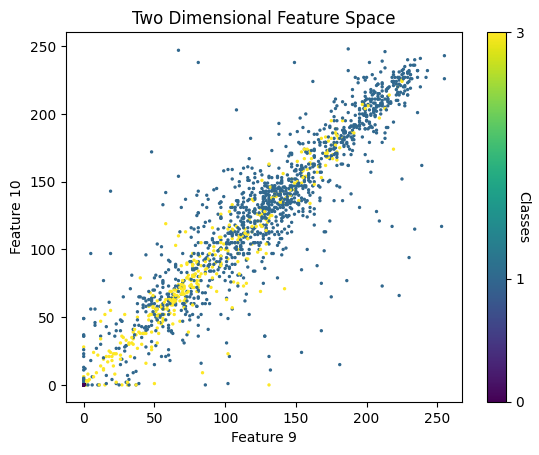

In [96]:
plot_2d_fspace(fspace_2classes)

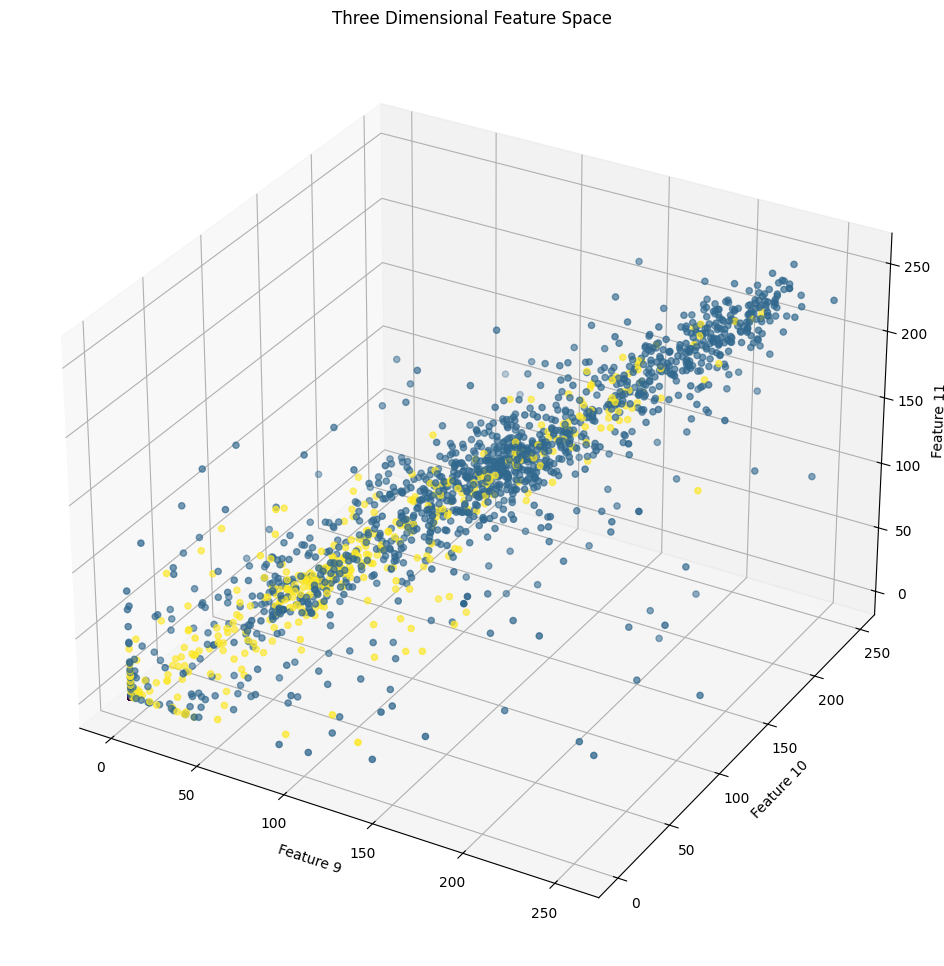

In [97]:
plot_3d_fspace(fspace_2classes)

Number of Observations: 255219
Dimension of the data: 256
Means:
0      20.468566
1      20.468903
2      20.469111
3      20.469217
4      20.469217
         ...    
251    21.297858
252    21.297858
253    21.297858
254    21.297858
255    21.297858
Length: 256, dtype: float64


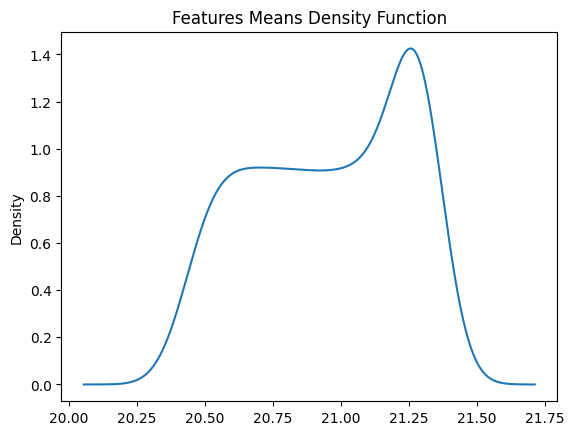

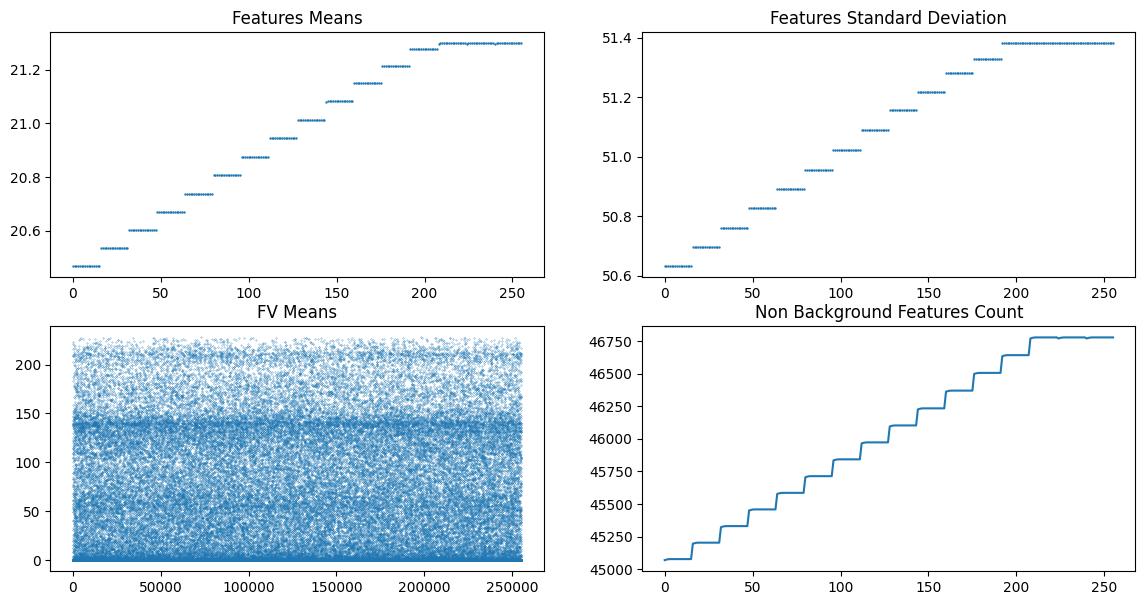

In [98]:
fspace_stat_descriptors(fspace)